In [1]:
library(argparse)
# library(Matrix)
library(ggplot2)
library(MASS)
library(rhdf5)
# library(BoutrosLab.plotting.general)
library(dplyr)
library(broom)


Attaching package: ‘dplyr’


The following object is masked from ‘package:MASS’:

    select


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




# Load h5 with simulated data

In [2]:
# h5="/iblm/netapp/data1/jezhou/crisprQTL/simulated_data_4guides_discrete_and_continuous/sim.h5"
h5="/iblm/netapp/data1/jezhou/crisprQTL/simulated_data_4guides_discrete_and_continuous_10-10-2022_4guides/sim.h5"

In [3]:
h5ls(h5)

,group,name,otype,dclass,dim
,<chr>,<chr>,<chr>,<chr>,<chr>
0,/,coeffs,H5I_DATASET,COMPOUND,13000
1,/,counts,H5I_GROUP,,
2,/counts,continuous,H5I_DATASET,INTEGER,13000 x 50000
3,/counts,discrete,H5I_DATASET,INTEGER,13000 x 50000
4,/,guides,H5I_GROUP,,
5,/guides,metadata,H5I_DATASET,COMPOUND,4000
6,/guides,noisy_guide_efficiencies,H5I_DATASET,COMPOUND,4000
7,/guides,one_hot,H5I_DATASET,INTEGER,50000 x 4000
8,/,linear_predictor,H5I_GROUP,,


Load values

In [4]:
coeffs <- h5read(h5, name = "coeffs")
cell.cycle.scores <- h5read(h5, "x/cell_cycle_scores")
scaling.factors <- h5read(h5, name = "scaling_factors")
guides.metadata <- h5read(h5, name = "guides/metadata") 
percent.mito <- h5read(h5, name = "x/percent_mito")
onehot.guides <- h5read(h5, name = "guides/one_hot")
noisy.efficiencies <- h5read(h5, name = "guides/noisy_guide_efficiencies")

In [5]:
head(coeffs)

,baselines,beta1,beta2,beta3,beta4
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.8231960,0,3.924515,2.798132,1.584211
2,-0.2226735,0,2.761231,4.971228,4.162559
3,0.7135972,0,3.237662,2.376847,3.164283
4,1.5395048,0,1.803297,2.110279,6.031446
5,1.3370643,0,1.548427,3.966994,1.536545
6,-1.7820493,0,4.300506,1.590969,1.960215


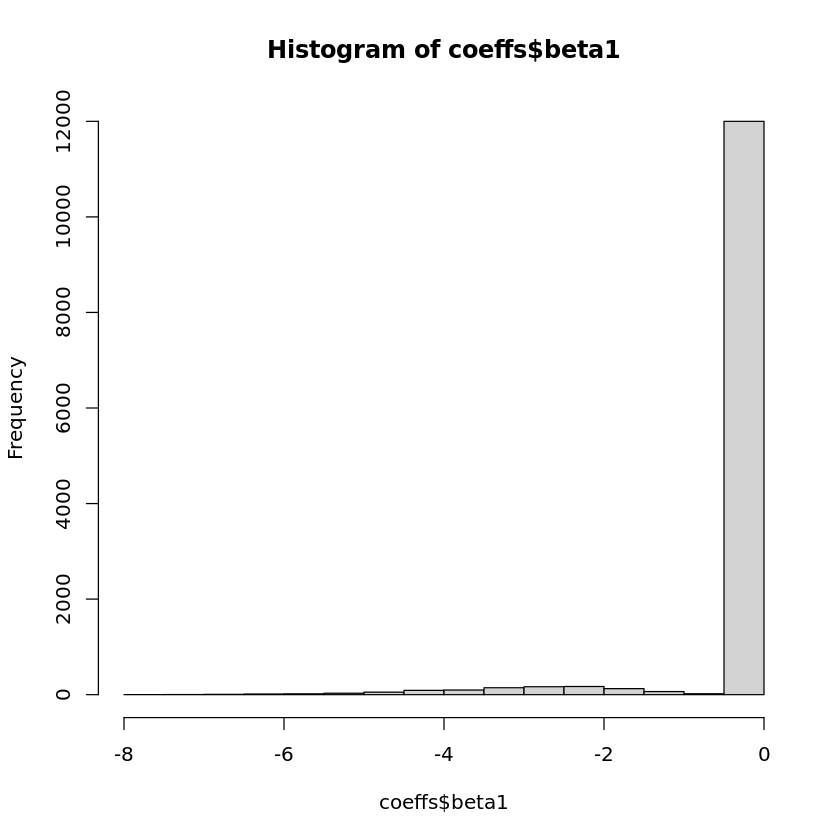

In [6]:
hist(coeffs$beta1)

In [7]:
head(guides.metadata)

,target.gene,efficiency,effect.size
,<int>,<dbl>,<dbl>
1,10485,0.4963379,-3.607479
2,11870,0.6271361,-3.297568
3,518,0.8094982,-3.020478
4,12341,0.3622067,-4.311901
5,1035,0.5298190,-1.776455
6,5131,0.8171457,-1.944886


### Check for gene that threw an error

In [46]:
genes.to.test <- unique(guides.metadata$target.gene)

In [47]:
which(genes.to.test==3414)

[1] 491

In [48]:
genes.to.test[490:492]


[1] 11662  3414  2022

# Test: model counts generated with continuous $X_1$ and fitting with continuous $X_1$ calculated from noisy (D=100) guide efficiency

In [49]:
head(noisy.efficiencies)

,1,10,100,guide,true
,<dbl>,<dbl>,<dbl>,<int>,<dbl>
1,0.0009381698,0.6621746,0.5070362,1,0.4963379
2,0.1280993461,0.8013760,0.6101027,2,0.6271361
3,0.7468066703,0.5945760,0.8233006,3,0.8094982
4,0.8523849145,0.2996767,0.3828461,4,0.3622067
5,0.0472172250,0.5514425,0.4999276,5,0.5298190
6,0.7086300104,0.7568990,0.8626259,6,0.8171457


In [13]:
guide.efficiencies <- noisy.efficiencies$'10'
head(guide.efficiencies)

[1] 0.6621746 0.8013760 0.5945760 0.2996767 0.5514425 0.7568990

In [14]:
length(guide.efficiencies)

[1] 4000

Test gene that threw error 

In [15]:
tg <- 3414

obs.counts <- h5read(file = h5, name = "counts/continuous", index = list(tg, 1:50000))


In [16]:
guides.for.gene <- sample(which(guides.metadata$target.gene == tg), 4)
temp.mtx <- t(as.numeric(guide.efficiencies[guides.for.gene])*t(onehot.guides[,guides.for.gene]))
x1 <- apply(temp.mtx, 1, function(x) {1-prod(1-x)})

In [17]:
gene.data <- data.frame(guide.eff = x1,
                    s.score = cell.cycle.scores$s.scores,
                    g2m.score = cell.cycle.scores$g2m.scores,
                    percent.mito = percent.mito,
                    counts = as.integer(obs.counts),
                    scaling.factor = scaling.factors)

In [18]:
unique(x1)

[1] 0.0000000 0.8283598 0.7046882 0.6225668 0.1327107 0.9493126 0.6726563
[8] 0.8885395 0.7438793

In [19]:
coeffs[3414,]

,baselines,beta1,beta2,beta3,beta4
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3414,3.398492,-7.956943,3.079226,2.212223,1.968278


Test `tryCatch()` function

In [20]:
alt <- tryCatch({
    glm.nb(counts ~ guide.eff + s.score + g2m.score + percent.mito + offset(log(scaling.factor)), 
           data = gene.data)
}, error = function(err) {
    print(paste("MY_ERROR: ",err))
    return(NULL)
})

[1] "MY_ERROR:  Error: no valid set of coefficients has been found: please supply starting values\n"


In [21]:
alt

NULL

In [37]:
# n.errors <- 0
# genes.with.errors <- c()
j <- 1
mods <- list()
# genes.success <- c()
# success.ix <- 1

for (i in 490:492) {
    print(i)
    tg <- genes.to.test[i]
    print(tg)
    obs.counts <- h5read(file = h5, name = "counts/continuous", index = list(tg, 1:50000))
    guides.for.gene <- sample(which(guides.metadata$target.gene == tg), 4)
    temp.mtx <- t(as.numeric(guide.efficiencies[guides.for.gene])*t(onehot.guides[,guides.for.gene]))
    x1 <- apply(temp.mtx, 1, function(x) {1-prod(1-x)})
    
    gene.data <- data.frame(guide.eff = x1,
                    s.score = cell.cycle.scores$s.scores,
                    g2m.score = cell.cycle.scores$g2m.scores,
                    percent.mito = percent.mito,
                    counts = as.integer(obs.counts),
                    scaling.factor = scaling.factors)
    
    print('modeling data')
    alt <- tryCatch({
        glm.nb(counts ~ guide.eff + s.score + g2m.score + percent.mito + offset(log(scaling.factor)), 
               data = gene.data)
    }, error = function(err) {
        print(paste("MY_ERROR: ",err))
        return(NA)
    })
    
    print(alt)
    mods[[j]] <- alt
    j <- j + 1
    
}

[1] 490
[1] 11662
[1] "modeling data"

Call:  glm.nb(formula = counts ~ guide.eff + s.score + g2m.score + percent.mito + 
    offset(log(scaling.factor)), data = gene.data, init.theta = 1.508919868, 
    link = log)

Coefficients:
 (Intercept)     guide.eff       s.score     g2m.score  percent.mito  
       4.685        -4.089         4.966         5.164         2.502  

Degrees of Freedom: 49999 Total (i.e. Null);  49995 Residual
Null Deviance:	    163400 
Residual Deviance: 55270 	AIC: 280300
[1] 491
[1] 3414
[1] "modeling data"
[1] "MY_ERROR:  Error: no valid set of coefficients has been found: please supply starting values\n"
[1] NA
[1] 492
[1] 2022
[1] "modeling data"

Call:  glm.nb(formula = counts ~ guide.eff + s.score + g2m.score + percent.mito + 
    offset(log(scaling.factor)), data = gene.data, init.theta = 1.440306031, 
    link = log)

Coefficients:
 (Intercept)     guide.eff       s.score     g2m.score  percent.mito  
       1.533        -8.136         2.048         1.699

In [38]:
mods

[[1]]

Call:  glm.nb(formula = counts ~ guide.eff + s.score + g2m.score + percent.mito + 
    offset(log(scaling.factor)), data = gene.data, init.theta = 1.508919868, 
    link = log)

Coefficients:
 (Intercept)     guide.eff       s.score     g2m.score  percent.mito  
       4.685        -4.089         4.966         5.164         2.502  

Degrees of Freedom: 49999 Total (i.e. Null);  49995 Residual
Null Deviance:	    163400 
Residual Deviance: 55270 	AIC: 280300

[[2]]
[1] NA

[[3]]

Call:  glm.nb(formula = counts ~ guide.eff + s.score + g2m.score + percent.mito + 
    offset(log(scaling.factor)), data = gene.data, init.theta = 1.440306031, 
    link = log)

Coefficients:
 (Intercept)     guide.eff       s.score     g2m.score  percent.mito  
       1.533        -8.136         2.048         1.699         3.391  

Degrees of Freedom: 49999 Total (i.e. Null);  49995 Residual
Null Deviance:	    36450 
Residual Deviance: 33950 	AIC: 64630


Fit model to problematic case

In [122]:
alt <- glm.nb(counts ~ guide.eff + s.score + g2m.score + percent.mito + offset(log(scaling.factor)), 
    data = gene.data,
             start = c(3,-2,3,2,2))

ERROR: Error: no valid set of coefficients has been found: please supply starting values


In [114]:
alt


Call:  glm.nb(formula = counts ~ s.score + g2m.score + percent.mito + 
    offset(log(scaling.factor)), data = gene.data, start = c(3, 
    3, 2, 2), init.theta = 1.429080043, link = log)

Coefficients:
 (Intercept)       s.score     g2m.score  percent.mito  
       3.373         3.090         2.216         2.085  

Degrees of Freedom: 49999 Total (i.e. Null);  49996 Residual
Null Deviance:	    66310 
Residual Deviance: 53280 	AIC: 171700

Check distribution of efficiency values and continuous $X_1$ for problematic gene

In [46]:
noisy.efficiencies[guides.for.gene,]

,1,10,100,guide,true
,<dbl>,<dbl>,<dbl>,<int>,<dbl>
1491,0.5619050322,0.7046882,0.9769464,1491,0.9042024
3491,0.0005734737,0.6225668,0.6380901,3491,0.6281592
491,0.3285826763,0.1327107,0.4017791,491,0.4553216
2491,0.8481542950,0.8283598,0.8658997,2491,0.8157615


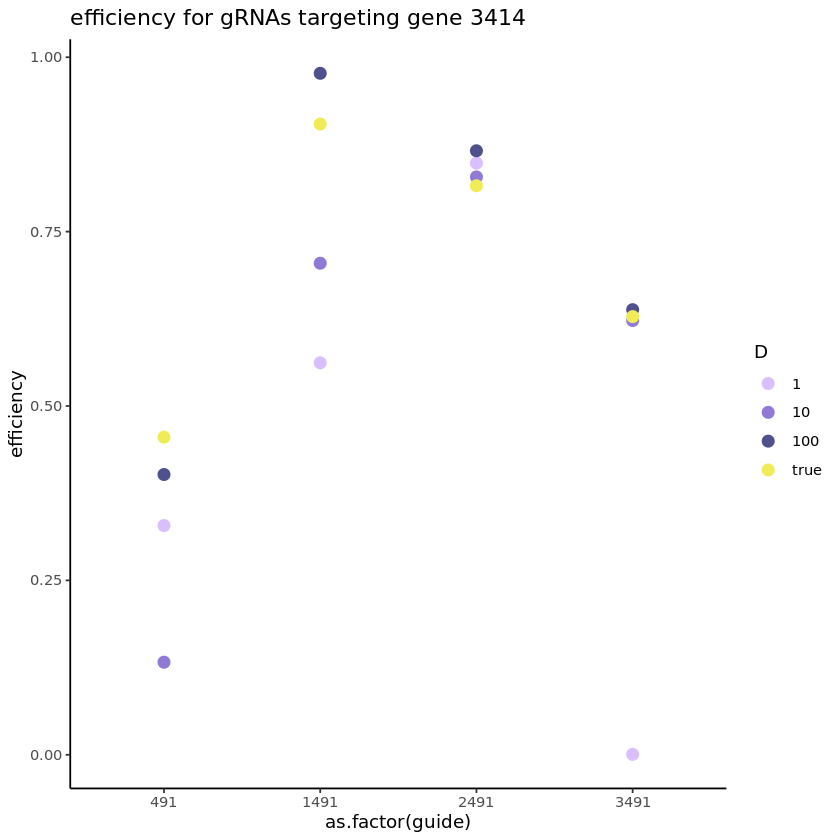

In [92]:
plotdf <- noisy.efficiencies[guides.for.gene,] %>% tidyr::pivot_longer(!guide, names_to = "D", values_to = "efficiency")

group.colors <- c(`1` = "#DABFFF", `10` = "#907AD6", `100` ="#4F518C", `true` = "#F0EC57")


ggplot(plotdf, aes(x = as.factor(guide), y = efficiency, color = D)) +
            geom_point(size = 3) + 
            scale_color_manual(values = group.colors)+
            theme_classic() + ggtitle('efficiency for gRNAs targeting gene 3414')

In [57]:
x1.mtx <- matrix(0, 4, 50000)
i <- 1
for (d in c(1, 10, 100)) {
    efficiencies <- noisy.efficiencies[,as.character(d)]
    temp.mtx <- t(as.numeric(efficiencies[guides.for.gene])*t(onehot.guides[,guides.for.gene]))
    x1 <- apply(temp.mtx, 1, function(x) {1-prod(1-x)})
    x1.mtx[i,] <- x1
    i <- i + 1
}

In [74]:
# get values of x1 based on true efficiencies
temp.mtx <- t(as.numeric(guides.metadata$efficiency[guides.for.gene])*t(onehot.guides[,guides.for.gene]))
x1 <- apply(temp.mtx, 1, function(x) {1-prod(1-x)})
x1.mtx[i,] <- x1

In [86]:
x1.df <- as.data.frame(x1.mtx)
rownames(x1.df) <- c('1', '10', '100', 'true')
x1.df <- as.data.frame(t(x1.df))
x1.df$cell <- 1:50000
x1.plotdf <- x1.df %>% tidyr::pivot_longer(!cell, names_to = "D", values_to = "x1")


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



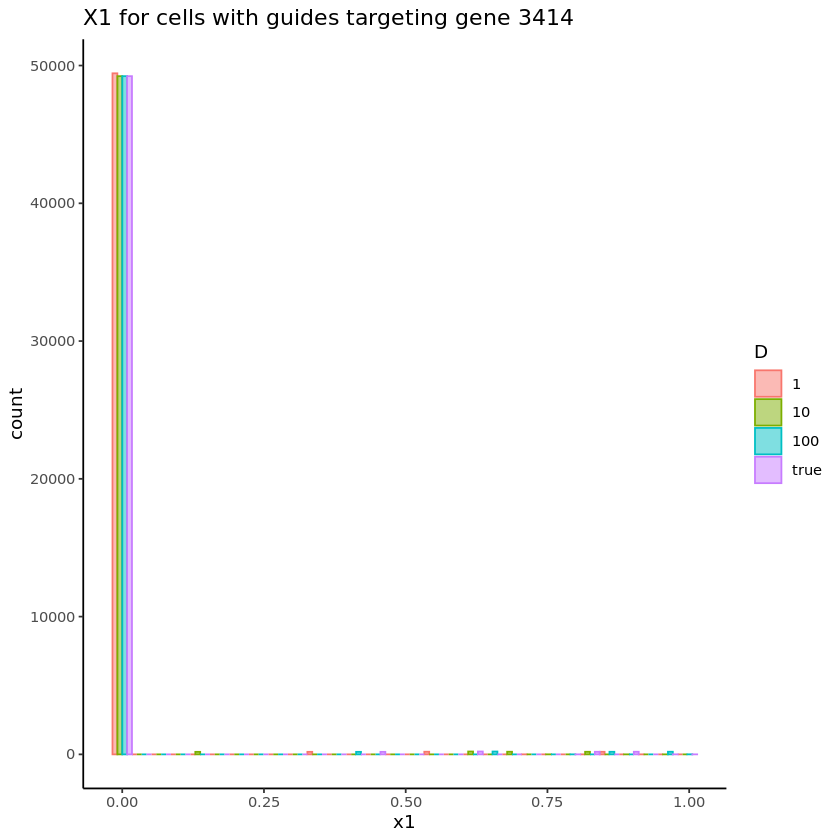

In [93]:
ggplot(x1.plotdf, aes(x = x1, fill = D, color = D)) + geom_histogram(position = "dodge", alpha = 0.5) + theme_classic() + ggtitle("X1 for cells with guides targeting gene 3414")

# Test: model counts generated with continuous $X_1$ and fitting with discrete $X_1$

In [180]:
# initialize lists for collecting fitted model data
i <- 1
alt.list <- list()
null.list <- list()
alt.coeffs.df <- list()
null.coeffs.df <- list()

In [181]:
# initialize matrix of X1 values (different set of values for each gene)
targeting <- TRUE

x1.mtx <- NULL

if (targeting) {
    x1.mtx <- matrix(0, length(unique(guides.metadata$target.gene)), 50000)
} else {
    x1.mtx <- matrix(0, 13000, 50000)
}

In [182]:
genes.to.test <- 1:13000
if (targeting) {
    genes.to.test <- unique(guides.metadata$target.gene)
}

genes.to.test

[1] 10380  7614  4828  2697 10343  5735  1099 10330  4869  8087  3047 10606
  [13]  9568  2713 10272  7172 10671  8094  6395 12190  7866  9344 12465  8858
  [25]  7103   778  6475  4954  1941  8280 11522  4422  4183 12447 10990  4973
  [37]  8034   564 11003  8356 12388  3630  9055  5233  8077     7  1556 11210
  [49]  4445    36 12946  6611  3401  8572   174  9309  5630  5799   205  2723
  [61] 10095  8912  7844  4295  1889  2263  9738  3879  9248  1778  1545  8327
  [73]  1537  5679  2682  1178  4249  4778 12370 12358  1504  9609  6053  2631
  [85]  2651 11608  7512  7504  3222  4733 11538 10654  7599  9850  9878 10014
  [97]  4214  7957  4062  6948  9012  7945  6803 10823  3154 11759  3614  8662
 [109]  4634  1469 10300  2382 12440  2758  6088  3853  1130  4992  7105  1232
 [121]  5148  6802  2198  3309  2214  2591   627 11054 11498 11190  1463 10189
 [133]  6032    12  6055  8266 10224  4370 10784  9866  7018 10778  2793 10833
 [145]  1934 11731  9021  4715  3187   575    34 11055  9280 10449 12093  4875
 [157]  4437  4013  9203  7351  3798  7561 12489  8634  1229 12796  7465  7391
 [169] 10354 12615 11582   399   573  6378  1745  9845  5331  4642 10594  3915
 [181]  1942  6864 10269  8183  3702  3689  4241  5980  1374  7189 11036  3531
 [193]  2794 11407 10100  1060  7591  4203  9705  7257  3513  8445  5142  4095
 [205]  8460 11822  3466  1277  2846   983  6468  9504  4432  6116  6361    78
 [217]  5262 11195  1282 11065  3015  9835   591  8466  8285  8308 10978 11285
 [229]  3787  5769 10581 10322  7855  7883  2041  5884  1126  9524  3397  9916
 [241]  7565  3272  9796  9246   808  9093 11298  2159  2286   261  3393  2678
 [253]  8530 10570  1380  5037  8647 12048   429  4298 10754 11202  7167  4776
 [265]   465  3428  3322 11343 12963   114  8783  8244   140   964   803  3275
 [277] 11492 10855 12065  6923   612  5928  6910  4925  3008 11008  2613  8513
 [289]  3530  8643  9038  7175   348 10360 11247  6862  3496 12777 12680  6782
 [301]  4674  2981 11678 10486 10440 10149  4728 12404   741  2011  3447  3742
 [313]  2944  3709  8206   199  8400  1787 11689  7246 12327  1616  9736 10106
 [325]  6585  5693  4313  6416 10190 11543  4050  8683  2196  5720 11857 12785
 [337]  5289  4609   930  5675  6171  5052  3186 12284  2776 12254 11477  3732
 [349] 12902 11460 10008  8326  2902   929  1560 12943   208 12484  7025 10446
 [361] 12270  6733  4829  5588  4593  2440  9298  2012 10513 12085  8684 12356
 [373]  1011  5280  8972  9940  5894   415   455  1912  9257  5728  6157  4297
 [385]  9925   341 11137 10387  8924  5954  8848  9137  4877  5617  6790  6254
 [397] 11610  7736 11873 11882  8473  7058  8056 12879  8145  7602   223   493
 [409]  5907  9667  7668   646  1039   305  5247  9440 12445  7647  9108  3768
 [421]   102  6644  1387  6028  7783  1358  5564   409  7126 12665  8617  4336
 [433] 12982  7878  7093  2536  2202 10907  1875   844  2240  7927 10435  7470
 [445]  6242  9885  7835  5915 10632  1193 11887 12954  1662 11119  2556  6278
 [457]  6660   597  3189  7225 11493 12509  9111  1506  8950  5641  1092 12960
 [469]  4496  9396  4988  4133  3893  7098  7085 12109 10685  1050 10888  2796
 [481]  2625  1893  1763 11220  9212  5582  8760 12191  8983  8715  8522 11788
 [493]  4948 10669   726   292 12038  7832  3850  7976  5431  2509  4011 12502
 [505]  8241  1388  7057  6983 11233  5913  5612  9564 11505 11402  8269  6654
 [517]   574  6488 11734    86  5870  7338  3604  4792  6322  2223  5499   340
 [529] 12618 10633  6590 12478 10814 11277  1389 11267   941 11863  3463  1070
 [541]  9121  2437  7910  9329  3012  9981  6913 10166  7398 11919  8024  9795
 [553]  3050  5381  2955 10865  9126 10998 11467 11051  4328   734 11096  4106
 [565] 11965  2113  2755  6051  9549  6442  8736  2149  2650 11937  4923  8027
 [577]  8344  8541  2162  7483  9232 10470 10700  5510  1899 12099 12712  2006
 [589] 10560  9968  9798  6647 12908  9453  8567  5341  2587  7734  6292  9677
 [601] 10840 12713  8824    31 10020  1184  4764  634

In [210]:
tg <- genes.to.test[1]
print(tg)

obs.counts <- counts.cont[tg,]

if (tg %in% guides.metadata$target.gene) {
    cat(sprintf('gene %s is a target gene\n', tg))
    guides.for.gene <- which(guides.metadata$target.gene==tg)
    
#     guides.for.gene <- seq(which(guides.metadata$target.gene==tg)[1], which(guides.metadata$target.gene==tg)[1] + ((4-1)*1000), 1000)
    print(guides.for.gene)
    print(sample(guides.for.gene,2))
    temp.mtx <- t(as.numeric(guides.metadata$efficiency[guides.for.gene])*t(onehot.guides[,guides.for.gene]))
    
    ### calculate x1
    
    # true X1 (used for simulating counts)
    x1.true <- as.numeric(h5read(h5, "x/x1_continuous", index = list(tg, 1:50000)))
    # continuous x1 calculated from recorded guide efficiencies
    x1.new <- apply(temp.mtx, 1, function(x) {1-prod(1-x)})
    # calculate indicator x1
    onehot.gene <- onehot.guides[,guides.for.gene]
    x1.indic <- as.integer(apply(onehot.gene, 1, function(x) any(x!=0)))
}

[1] 10380
gene 10380 is a target gene
[1]    1 1001 2001 3001
[1] 1001 2001


In [211]:
gene.data <- data.frame(guide.eff = x1.new,
                    s.score = cell.cycle.scores$s.scores,
                    g2m.score = cell.cycle.scores$g2m.scores,
                    percent.mito = percent.mito,
                    counts = as.integer(obs.counts),
                    scaling.factor = scaling.factors)

In [212]:
alt <- glm.nb(counts ~ guide.eff + s.score + g2m.score + percent.mito + offset(log(scaling.factor)), 
    data = gene.data)
alt.list[[i]] <- alt
print(alt)



Call:  glm.nb(formula = counts ~ guide.eff + s.score + g2m.score + percent.mito + 
    offset(log(scaling.factor)), data = gene.data, init.theta = 1.481951451, 
    link = log)

Coefficients:
 (Intercept)     guide.eff       s.score     g2m.score  percent.mito  
       3.466        -1.526         2.621         2.852         2.110  

Degrees of Freedom: 49999 Total (i.e. Null);  49995 Residual
Null Deviance:	    73130 
Residual Deviance: 53610 	AIC: 178400


In [213]:
t(coeffs[tg,])

,10380
baselines,3.472363
beta1,-1.523939
beta2,2.662179
beta3,2.856572
beta4,1.923186


In [216]:
counts = "continuous"

for (tg in genes.to.test[1:10]) {
    cat(sprintf("modeling target gene %d\n", tg))
    
    ### compile data for model
    print('getting observed counts for gene')
    obs.counts <- numeric(50000)
    if (counts == "continuous") {
#         obs.counts <- h5read(h5, name = "counts/continuous", index = list(tg, 1:50000))
        obs.counts <- counts.cont[tg,]
    } else {
#         obs.counts <- h5read(h5, name = "counts/discrete", index = list(tg, 1:50000))
        obs.counts <- counts.disc[tg,]
    }
    
    if (tg %in% guides.metadata$target.gene) {
        cat(sprintf('gene %s is a target gene\n', tg))
        guides.for.gene <- which(guides.metadata$target.gene==tg)

        print(guides.for.gene)
        temp.mtx <- t(as.numeric(guides.metadata$efficiency[guides.for.gene])*t(onehot.guides[,guides.for.gene]))

        ### calculate x1

#         # true X1 (used for simulating counts)
#         x1.true <- as.numeric(h5read(h5, "x/x1_continuous", index = list(tg, 1:50000)))
#         # continuous x1 calculated from recorded guide efficiencies
#         x1.new <- apply(temp.mtx, 1, function(x) {1-prod(1-x)})
        # calculate indicator x1
        onehot.gene <- onehot.guides[,guides.for.gene]
        x1.indic <- as.integer(apply(onehot.gene, 1, function(x) any(x!=0)))
    }
    # compile df 
    gene.data <- data.frame(guide.eff = x1.indic,
                        s.score = cell.cycle.scores$s.scores,
                        g2m.score = cell.cycle.scores$g2m.scores,
                        percent.mito = percent.mito,
                        counts = as.integer(obs.counts),
                        scaling.factor = scaling.factors)

    ### fit alt model 
    alt <- glm.nb(counts ~ guide.eff + s.score + g2m.score + percent.mito + offset(log(scaling.factor)), 
        data = gene.data)
    alt.list[[i]] <- alt
    
    i <- i + 1
}

modeling target gene 10380
[1] "getting observed counts for gene"
gene 10380 is a target gene
[1]    1 1001 2001 3001
modeling target gene 7614
[1] "getting observed counts for gene"
gene 7614 is a target gene
[1]    2 1002 2002 3002
modeling target gene 4828
[1] "getting observed counts for gene"
gene 4828 is a target gene
[1]    3 1003 2003 3003
modeling target gene 2697
[1] "getting observed counts for gene"
gene 2697 is a target gene
[1]    4 1004 2004 3004
modeling target gene 10343
[1] "getting observed counts for gene"
gene 10343 is a target gene
[1]    5 1005 2005 3005
modeling target gene 5735
[1] "getting observed counts for gene"
gene 5735 is a target gene
[1]    6 1006 2006 3006
modeling target gene 1099
[1] "getting observed counts for gene"
gene 1099 is a target gene
[1]    7 1007 2007 3007
modeling target gene 10330
[1] "getting observed counts for gene"
gene 10330 is a target gene
[1]    8 1008 2008 3008
modeling target gene 4869
[1] "getting observed counts for gene"
g